# Gasprices along commute route

As a German weekend commuter (and more) I am interested which region typically has the lowest gas prices. Thanks to publicly available gas prices via several APIs of providers registered with the Federal Cartel Office http://www.bundeskartellamt.de/DE/Wirtschaftsbereiche/Mineral%C3%B6l/MTS-Kraftstoffe/mtskraftstoffe_node.html and some Python data processing this question has been answered.

In [1]:
%matplotlib inline

import gpxpy
import json
import os
import psycopg2
from socket import gethostname
import math
from pprint import pformat

import requests
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

from shapely.geometry import Point,LineString,Polygon
import shapely.wkt

import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import geojson
import lxml.html

from ipywidgets import widgets
from ipywidgets import FloatProgress
from IPython.display import display

In [2]:
data_dir = "../../../data/"
deg2km = 111
crs_default={'init': 'epsg:4326'}
hostname = gethostname()

with open(os.path.join("./config.json")) as f:
    config = json.load(f)
conn = psycopg2.connect(**config['db'][hostname])
apikey = config['tankerkoenig']['apikey']
config['db'][hostname]['user']     = '********'
config['db'][hostname]['password'] = '********'
#API key for access to the free Tankerkönig-Spritpreis-API
#Register at https://creativecommons.tankerkoenig.de for a key
config['tankerkoenig']['apikey'] = '********-****-****-****-************'

print("This is how the config file looks like:\n\n{}".format(pformat(config)))

config['buffer'] = 2
def f(x):
    config['buffer'] = x
# http://ipywidgets.readthedocs.io/en/stable/user_install.html
widgets.interact(f, x=widgets.IntSlider(min=1,max=11,step=1,value=6));


This is how the config file looks like:

{'db': {'T530-2017': {'database': 'tankerkoenig',
                      'host': '127.0.0.1',
                      'password': '********',
                      'port': 5432,
                      'user': '********'}},
 'tankerkoenig': {'apikey': '********-****-****-****-************',
                  'chunksize': 10,
                  'url_prices': 'https://creativecommons.tankerkoenig.de/json/prices.php'}}


## The track

This notebook operates on a GPX file export from my routing app. The code is prepared for multiple tracks (e.g. alternatives) but currently works on the first track only.

The line between all points of the GPX track is then enlarged with the geospatial buffer() method https://toblerity.org/shapely/manual.html#object.buffer . This is the first example of geospatial data processing in this code -- there is much more to it!

In [3]:
gpx_file = open(data_dir+'WOB-LDK.gpx', 'r')
gpx_file_parsed = gpxpy.parse(gpx_file)

#list_gpx_data = []
list_gpx_tracks = []
for track in gpx_file_parsed.tracks:
    tmp_track = {}
    name = lxml.html.document_fromstring(track.name).text_content()
    #print(name)
    tmp_track['name'] = name
    tmp_track['points'] = []
    #import html
    #print(html.unescape(track.name))
    for segment in track.segments:
        for point in segment.points:
            #list_gpx_data.append([point.longitude, point.latitude])
            tmp_track['points'].append([point.longitude, point.latitude])
    tmp_track['buffered'] = LineString(tmp_track["points"]).buffer(config['buffer']/deg2km)
    tmp_track['crs'] = crs_default
    list_gpx_tracks.append(tmp_track)

#taking only the first track here
#todo: iterate
geodataseries_track = gpd.GeoSeries.from_array(
    LineString(list_gpx_tracks[0]["points"]).simplify(0.001)
)
geodataseries_track.crs = crs_default

geodataseries_track_buffered = gpd.GeoSeries.from_array(
    Polygon(list_gpx_tracks[0]["buffered"]).simplify(0.001)
)
geodataseries_track_buffered.crs = crs_default

# Now create a GeoPandas DataFrame from it
#https://gis.stackexchange.com/a/174168/87254 et al
geodataframe_track = gpd.GeoDataFrame(["FOO"],
                       crs={'init': 'epsg:4326'},
                       geometry=geodataseries_track)

geodataframe_track_buffered = gpd.GeoDataFrame(["BAR"],
                       crs={'init': 'epsg:4326'},
                       geometry=geodataseries_track_buffered)

#bufferedpolygon_track = geodataframe_track.unary_union.buffer(config['buffer']/deg2km)

In [4]:
#writing to the filesystem
with open('geodataframe_track.geojson', 'w') as f:
    f.write(geodataframe_track.to_json())
with open('geodataframe_track_buffered.geojson', 'w') as f:
    f.write(geodataframe_track_buffered.to_json())

## Geodata in Databases

The German gas stations are stored locally from a PostgreSQL database dump from the API provider. Very nice of them, and much more performant! The data model could easily be extended to contain PostGIS geometry but here a simple SELECT is made by the supplied latitude anc longitude columns.

In [5]:
bounds = geodataframe_track_buffered.bounds

querystring = ('SELECT "id", "name", "brand", "post_code", "place", "lat", "lng" from "gas_station" as station '
              ' WHERE lng >= '+str(math.floor(bounds['minx'].max())*1 )+
              ' AND lng <= '+str(math.ceil(bounds['maxx'].max())*1 )+
              ' AND lat >= '+str(math.floor(bounds['miny'].max())*1 )+
              ' AND lat <= '+str(math.ceil(bounds['maxy'].max())*1 )+
              ';')

dataframe_gasstations = pd.read_sql_query(querystring,con=conn)
# https://cambridgespark.com/content/tutorials/geopandas/index.html
geometry = [Point(xy) for xy in zip(dataframe_gasstations.lng, dataframe_gasstations.lat)]
geodataframe_stations = gpd.GeoDataFrame(dataframe_gasstations, crs=crs_default, geometry=geometry)
conn.close()

## More geodata relations

Another basic comparison: For each of the selected gas stations from the database, is its location within https://toblerity.org/shapely/manual.html#object.within the buffered route?

In [6]:
#http://jgardiner.co.uk/blog/jupyter_progress_bar
progressbar = FloatProgress(min=0, max=len(geodataframe_stations), description="filter stations")
display(progressbar)

stations_in_vincinity = []
#list_stations_within_line_track_buffered

track_buffered_simplified = Polygon(list_gpx_tracks[0]["buffered"]).simplify(0.001)
for index, row in geodataframe_stations.iterrows():
    #print(row)
    progressbar.value += 1
    #print(".", end="")
    if row.geometry.within(track_buffered_simplified):
        stations_in_vincinity.append(row)
progressbar.value = 0

## API calls

Finally the gas prices: For each of the gas stations this code asks the API endpoints for the current gas prices.

In [7]:
#http://stackoverflow.com/a/9671301
list_stations_chunked = [stations_in_vincinity[x:x+config["tankerkoenig"]["chunksize"]] for x in range(0, len(stations_in_vincinity), config["tankerkoenig"]["chunksize"])]

# this should implement a proper queue
params_request = []
for chunk in range(len(list_stations_chunked)):
    mydict = {}
    mylist = []
    mydict['apikey'] = apikey
    for station in range(len(list_stations_chunked[chunk])):
        mylist.append(list_stations_chunked[chunk][station]['id'])
    mydict['ids'] = ",".join(mylist)
    params_request.append(mydict)

In [8]:
#This is the worst part of the implementation as the scripts and 
#it should be moved to a background service with persistence.
# a network connection is required

progressbar_tk = FloatProgress(min=0, max=len(list_stations_chunked), description="call API")
display(progressbar_tk)

responses = []
valid_responses = {} #dict to have uuid as df index easily
j=0
delay = 20
delay_min = 20
delay_max = 90
backoff = 1.6
#for each in params_request:
while j<len(params_request): #len() is evaluated each iteration
    response = requests.get(config["tankerkoenig"]["url_prices"], params=params_request[j])
    progressbar_tk.value += 1
    if (response.status_code != 200):
        print("Attention! Status code is {}.".format(response.status_code))
        #print("Collected so far: ", len(valid_responses))
        #break #loosing the ability to re-request here
        j += 1
        if (delay * backoff) <= delay_max:
            delay = delay * backoff
        #pass
    else:
        #the following needs error handling
        data = response.json()
        if data['ok'] == True:
            if (delay / backoff) > delay_min:
                delay = delay / backoff
            else:
                pass
            for index, content in data['prices'].items():
                if data['prices'][index]['status'] == 'open':
                    valid_responses[index] = data['prices'][index]
            del params_request[j]
        else:
            pass
            j += 1 #something must have een wrong with the data
        #break #break here for just 1 iteration of the params_request loop (i.e. only 10 stations)
    #print("{}-{}/{}, d:{}, v:{}; ".format(j, i,len(params_request),delay,len(valid_responses)))
    time.sleep(delay)  if j < len(params_request) else print("ready")

progressbar_tk.value = 0

ready


## Python data processing

Plenty of, and even more than needed, dataprocessing on the returned results. The metadata from the database is preserved, but only currently open stations kept, and cleaning is done.

In [9]:
dataframe_stations_in_vincinity = pd.DataFrame(stations_in_vincinity)
dataframe_stations_in_vincinity = dataframe_stations_in_vincinity.set_index('id')

dataframe_stations_valid_responses = pd.DataFrame(valid_responses)
dataframe_stations_valid_responses = dataframe_stations_valid_responses.T

dataframe_analysis = pd.concat([dataframe_stations_in_vincinity, dataframe_stations_valid_responses], axis=1)
dataframe_analysis[['diesel', 'e5', 'e10']] = dataframe_analysis[['diesel', 'e5', 'e10']].astype(float)
dataframe_analysis.diesel = dataframe_analysis.diesel.replace({ 0 : np.nan })
dataframe_analysis.e5 = dataframe_analysis.e5.replace({ 0 : np.nan })
dataframe_analysis.e10 = dataframe_analysis.e10.replace({ 0 : np.nan })

dataframe_analysis = dataframe_analysis[dataframe_analysis['diesel'] > 0]
dataframe_analysis = dataframe_analysis[dataframe_analysis['e10'] > 0]
dataframe_analysis = dataframe_analysis[dataframe_analysis['e5'] > 0]

#dataframe_analysis.describe()
#dataframe_analysis.columns.values

# https://stackoverflow.com/a/28577480
# cols_to_norm = ['diesel','e10', 'e5']
dataframe_analysis[['diesel_norm','e10_norm', 'e5_norm']] = dataframe_analysis[['diesel','e10', 'e5']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

dataframe_analysis[['diesel', 'e10', 'e5', 'diesel_norm', 'e10_norm', 'e5_norm']].describe()

,diesel,e10,e5,diesel_norm,e10_norm,e5_norm
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,1.192634,1.363854,1.386146,0.294537,0.368929,0.378897
std,0.040172,0.044534,0.044361,0.160689,0.193628,0.192875
min,1.119000,1.279000,1.299000,0.000000,0.000000,0.000000
25%,1.169000,1.339000,1.359000,0.200000,0.260870,0.260870
50%,1.189000,1.349000,1.379000,0.280000,0.304348,0.347826
75%,1.209000,1.389000,1.409000,0.360000,0.478261,0.478261
max,1.369000,1.509000,1.529000,1.000000,1.000000,1.000000


In [ ]:
#with open('dataframe_analysis.geojson', 'w') as f:
#    f.write(dataframe_analysis.drop(['geometry'], axis=1).to_json())

## Geodata visualization

Always handy to have a quick method to visually check the result during these hours of development on my train rides.

But the ecosystem even offers convenient ways to generate maps for webbrowser access.

In [10]:
geometry = [Point(xy) for xy in zip(dataframe_analysis.lng, dataframe_analysis.lat)]
geodataframe_analysis = gpd.GeoDataFrame(dataframe_analysis[['name', 'brand', 'post_code', 'place', 'lat', 'lng', 'diesel', 'e10', 'e5','diesel_norm', 'e10_norm', 'e5_norm', 'status', 'geometry']], crs=crs_default, geometry=geometry)


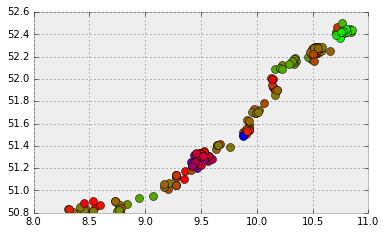

In [11]:
geodataframe_analysis.plot(column='e5', cmap='brg_r', markersize=8);

In [12]:
import folium
from folium.plugins import MarkerCluster, HeatMap

In [13]:
mymap = folium.Map([geodataframe_track.centroid[0].y, geodataframe_track.centroid[0].x],
                  zoom_start=7,
                  tiles='cartodbpositron')

#http://python-visualization.github.io/folium/quickstart.html#GeoJSON/TopoJSON-Overlays
track = os.path.join('.', 'geodataframe_track.geojson')
buffer = os.path.join('.', 'geodataframe_track_buffered.geojson')

folium.GeoJson(
    track,
    name='geojson'
).add_to(mymap)

# marker_cluster = MarkerCluster().add_to(mymap)
# points = []
# for index, row in dataframe_analysis.iterrows():
# #    #print(row.geometry)
#     points.append([row.lat, row.lng])
#     folium.Marker([row.lat, row.lng],popup=row.name+': '+str(row.e5)).add_to(marker_cluster)
#
#points = folium.features.GeoJson(gjson)
#map.add_child(points)

#folium.PolyLine(points).add_to(map)
#folium.PolyLine(list_gpx_data).add_to(mymap)


#stationArr = dataframe_analysis[['lat', 'lng', 'e5_norm']].values.tolist()
# hm_wide = HeatMap( stationArr, 
#                    min_opacity=0.0,
#                    radius=12, blur=12, 
#                    max_zoom=9,
#                    gradient={0.0: 'green', 0.5: 'yellow', 1: 'red'}
#                  )
# mymap.add_child(hm_wide)


f = folium.map.FeatureGroup(name="gas prices e5")

import branca
cm = branca.colormap.LinearColormap(['green', 'yellow', 'red'], 
                                    index=[0.1, 0.3, 0.7], vmin=0, vmax=1)

stationArr = dataframe_analysis[['lng', 'lat', 'e5_norm']].values.tolist()
for lng, lat, e5_norm in stationArr:
        folium.features.CircleMarker(
            location=[lat, lng],
    radius=4,
    color=None,
    fill=True,
    fill_color=cm(e5_norm)
        ).add_to(mymap)


mymap.save('test.html')
mymap

In [ ]:
# from selenium import webdriver
# browser = webdriver.Chrome()
# browser.get("test.html")
# #Give the map tiles some time to load
# time.sleep(delay)
# browser.save_screenshot('map.png')
# browser.quit()

## Appendix

In [14]:
import shapely
print(shapely.__version__)
import shapely.geos
print(shapely.geos.geos_version)
print(shapely.geos.geos_version_string)

1.5.13
(3, 5, 1)
3.5.1-CAPI-1.9.1 r4246


The end.